<a href="https://colab.research.google.com/github/ANIL-BUSSA/LLINTERN/blob/main/StockMarketPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import yfinance as yf

# Download historical stock market data
ticker = 'AAPL'
data = yf.download(ticker, start='2010-01-01', end='2024-04-01')
data.to_csv('AAPL.csv')


[*********************100%%**********************]  1 of 1 completed


In [11]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the data
data = pd.read_csv('AAPL.csv', index_col='Date', parse_dates=True)

# Handling missing values
data = data.dropna()

# Feature Engineering
data['Change'] = data['Close'].pct_change()  # Example feature
data['Volume_Change'] = data['Volume'].pct_change()

# Drop rows with NaN values created by pct_change
data = data.dropna()

# Normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close', 'Volume', 'Change', 'Volume_Change']])

# Convert to DataFrame
scaled_data = pd.DataFrame(scaled_data, columns=['Close', 'Volume', 'Change', 'Volume_Change'], index=data.index)


In [12]:
import numpy as np

# Create sequences of 60 days of data to predict the next day's price
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:i+seq_length].values
        y = data.iloc[i+seq_length, 0]  # We will predict the 'Close' price
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Flatten the input for Linear Regression
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train the model
lr_model = LinearRegression()
lr_model.fit(X_train_flat, y_train)

# Predictions
lr_predictions = lr_model.predict(X_test_flat)

# Evaluate the model
lr_mse = mean_squared_error(y_test, lr_predictions)
print(f'Linear Regression MSE: {lr_mse}')


Linear Regression MSE: 0.00022556240087598476


In [14]:
from sklearn.svm import SVR

# Train the model
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_flat, y_train)

# Predictions
svm_predictions = svm_model.predict(X_test_flat)

# Evaluate the model
svm_mse = mean_squared_error(y_test, svm_predictions)
print(f'SVM MSE: {svm_mse}')


SVM MSE: 0.08980649951018656


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the RNN model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Predictions
rnn_predictions = model.predict(X_test)

# Evaluate the model
rnn_mse = mean_squared_error(y_test, rnn_predictions)
print(f'RNN MSE: {rnn_mse}')


Epoch 1/20
89/89 [==============================] - 9s 61ms/step - loss: 0.0028
Epoch 2/20
89/89 [==============================] - 6s 66ms/step - loss: 1.6094e-04
Epoch 3/20
89/89 [==============================] - 5s 54ms/step - loss: 1.3631e-04
Epoch 4/20
89/89 [==============================] - 6s 68ms/step - loss: 1.1234e-04
Epoch 5/20
89/89 [==============================] - 5s 53ms/step - loss: 2.5093e-04
Epoch 6/20
89/89 [==============================] - 5s 54ms/step - loss: 8.6233e-05
Epoch 7/20
89/89 [==============================] - 6s 68ms/step - loss: 8.6783e-05
Epoch 8/20
89/89 [==============================] - 5s 52ms/step - loss: 1.0375e-04
Epoch 9/20
89/89 [==============================] - 6s 70ms/step - loss: 6.9983e-05
Epoch 10/20
89/89 [==============================] - 5s 54ms/step - loss: 7.4076e-05
Epoch 11/20
89/89 [==============================] - 5s 53ms/step - loss: 1.4459e-04
Epoch 12/20
89/89 [==============================] - 6s 68ms/step - loss: 7.65

In [16]:
print(f'Linear Regression MSE: {lr_mse}')
print(f'SVM MSE: {svm_mse}')
print(f'RNN MSE: {rnn_mse}')


Linear Regression MSE: 0.00022556240087598476
SVM MSE: 0.08980649951018656
RNN MSE: 0.0008107085872282063


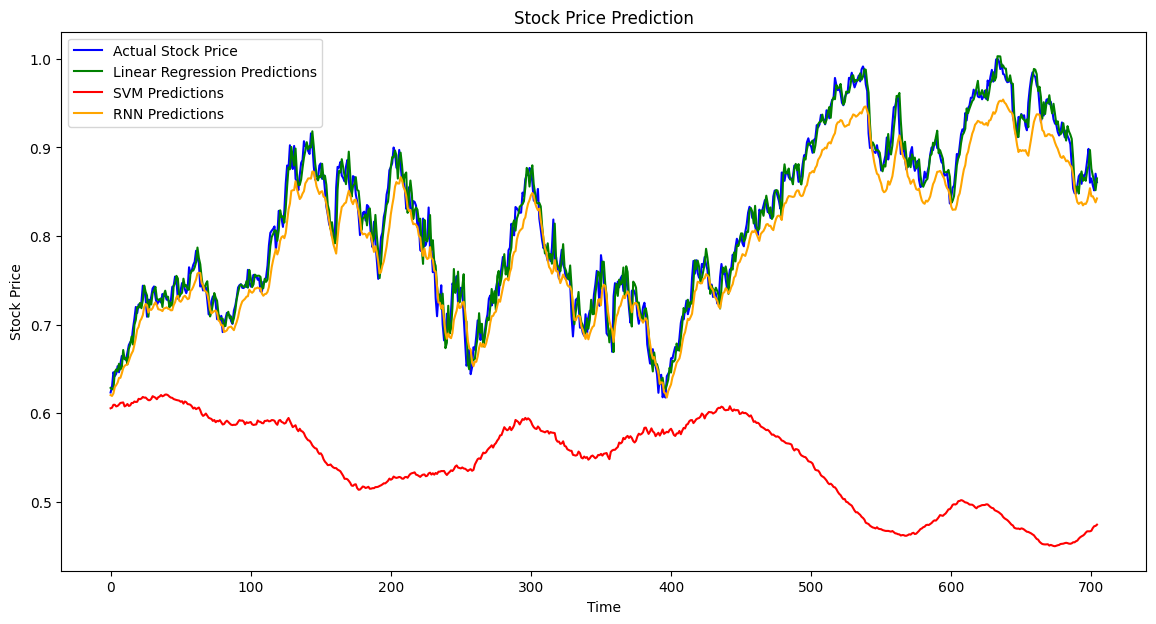

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(lr_predictions, color='green', label='Linear Regression Predictions')
plt.plot(svm_predictions, color='red', label='SVM Predictions')
plt.plot(rnn_predictions, color='orange', label='RNN Predictions')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
